In [2]:
import os
import shutil
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from rinet.data_sim import random_mixture_sample

# for reproducibility
SEED = 42
np.random.seed(SEED)


Matplotlib is building the font cache; this may take a moment.


In [3]:
# generate dataset

data_path = '../simulated_1d/'

n_dimensions = 1  # number of dimensions
n_components = [1, 2]  # possible number of pathological components
sample_sizes = [200, 300, 500, 1000, 5000, 10000]  # possible no. samples
mean_range = [-3, 3]  # min/max possible mean of distributions
pathological_dev_percentage_range = [30, 60]

n_samples = 10000

data = []  # list of vectors containing mixture samples
sizes = []
components = []
mean_vecs = []
std_devs = []
for i in range(n_samples):

    if i % 500 == 0:
        print(i)

    sample, mean_vectors, stds, comps, sz = random_mixture_sample(
        n_dimensions=n_dimensions, 
        n_components=np.random.choice(n_components),
        n_samples=np.random.choice(sample_sizes),
        quantize_step=np.random.choice([0, 0.05, 0.1, 0.2]),
        mean_range=mean_range,
        pathological_dev_percentage_range=pathological_dev_percentage_range
    )

    data.append(sample)
    mean_vecs.append(mean_vectors)
    std_devs.append(stds)
    components.append(comps)
    sizes.append(sz)



0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [4]:
# standardize samples, so model can be scale independent
data_scaled = []
targets = []
for c, i in enumerate(data):

    if c % 500 == 0:
        print(c)

    # record scaled data points
    data_scaled.append((i-i.mean(axis=0))/i.std(axis=0))

    # transform target statistics
    a = 1 / i.std(axis=0)  # reciprocal of sample std for scaling
    b = -i.mean(axis=0)  # negative of sample mean for shifting
    transformed_mean = a * (mean_vecs[c][0] + b)  # transform mean
    transformed_std = a * std_devs[c][0]

    # create NN target from standardized sample
    targets.append(np.hstack([
        transformed_mean,
        transformed_std,
        sizes[c][0]/sum(sizes[c])
    ]))


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [5]:
# split
idx_train, idx_test = train_test_split(
    range(len(data)),
    test_size=(2000/len(data)),
    random_state=10
)
assert len(set(idx_train).intersection(idx_test)) == 0, \
    'Error: train/test overlap'
idx_val, idx_test = train_test_split(
    idx_test,
    test_size=0.5,
    random_state=10
)
assert len(set(idx_val).intersection(idx_test)) == 0, \
    'Error: val/test overlap'

print(len(idx_train))
print(len(idx_val))
print(len(idx_test))


8000
1000
1000


In [6]:
# save generated data
if not os.path.exists(data_path):
    os.makedirs(data_path)
    os.makedirs(data_path+'/train/')
    os.makedirs(data_path+'/val/')
    os.makedirs(data_path+'/test/')
else:
    shutil.rmtree(data_path)
    os.makedirs(data_path)
    os.makedirs(data_path+'/train/')
    os.makedirs(data_path+'/val/')
    os.makedirs(data_path+'/test/')

for idx, split in zip([idx_train, idx_val, idx_test], ['train', 'val', 'test']):
    with open(data_path+'/' + split + '/input_data.pkl', 'wb') as handle:
        pickle.dump([data_scaled[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/original_data.pkl', 'wb') as handle:
        pickle.dump([data[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/target_data.pkl', 'wb') as handle:
        pickle.dump([targets[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/means.pkl', 'wb') as handle:
        pickle.dump([mean_vecs[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/stds.pkl', 'wb') as handle:
        pickle.dump([std_devs[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/sizes.pkl', 'wb') as handle:
        pickle.dump([sizes[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/components.pkl', 'wb') as handle:
        pickle.dump([components[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)


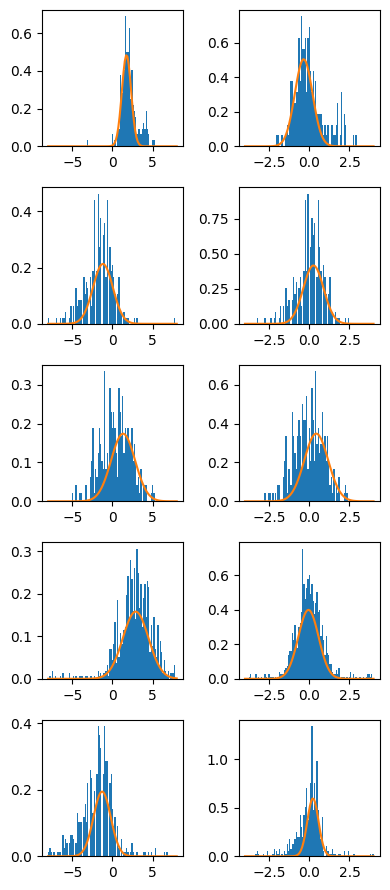

In [7]:
# checking transformation:

# does a sample using standardized target parameters match the reference Gaussian?

import matplotlib.pyplot as plt
from rinet.data_sim import plot_1d_mixture
from scipy.stats import norm

plt.figure(figsize=(4, 9))
x_range = np.linspace(-8, 8, 100)
x_range_standard = np.linspace(-4, 4, 100)
for i in range(5):

    idx = np.random.choice(len(data))  # select random sample index

    # plot unscaled data
    plt.subplot(5, 2, (i*2)+1)
    plt.hist(data[idx], x_range, density=True)
    pdf = norm(loc=mean_vecs[idx][0], scale=std_devs[idx][0]).pdf(x_range)
    pdf *= sizes[idx][0]/sum(sizes[idx])
    plt.plot(x_range, pdf)

    # plot scaled sample
    plt.subplot(5, 2, (i*2)+2)
    plt.hist(data_scaled[idx], x_range_standard, density=True)
    pdf = norm(loc=targets[idx][0], scale=targets[idx][1]).pdf(x_range_standard)
    pdf *= sizes[idx][0]/sum(sizes[idx])
    plt.plot(x_range_standard, pdf)

plt.gcf().tight_layout()


(array([  5.,  17.,  30.,  66.,  86., 108., 148., 192., 196., 232., 271.,
        305., 357., 341., 462., 489., 460., 589., 538., 568., 529., 497.,
        428., 454., 430., 389., 344., 305., 284., 222., 192., 132., 128.,
         72.,  41.,  20.,  31.,  21.,   7.,   5.,   3.,   4.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.15722433, 0.17954542, 0.2018665 , 0.22418758, 0.24650867,
        0.26882975, 0.29115083, 0.31347191, 0.335793  , 0.35811408,
        0.38043516, 0.40275624, 0.42507733, 0.44739841, 0.46971949,
        0.49204058, 0.51436166, 0.53668274, 0.55900382, 0.58132491,
        0.60364599, 0.62596707, 0.64828815, 0.67060924, 0.69293032,
        0.7152514 , 0.73757249, 0.75989357, 0.78221465, 0.80453573,
        0.82685682, 0.8491779 , 0.87149898, 0.89382006, 0.91614115,
        0.93846223, 0.96078331, 0.9831044 , 1.00542548, 1.02774656,
        1.05006764, 1.07238873, 1.09470981, 1.11703089, 1.13935197,
        1.16167306, 1.18399414, 1.20631522, 1.

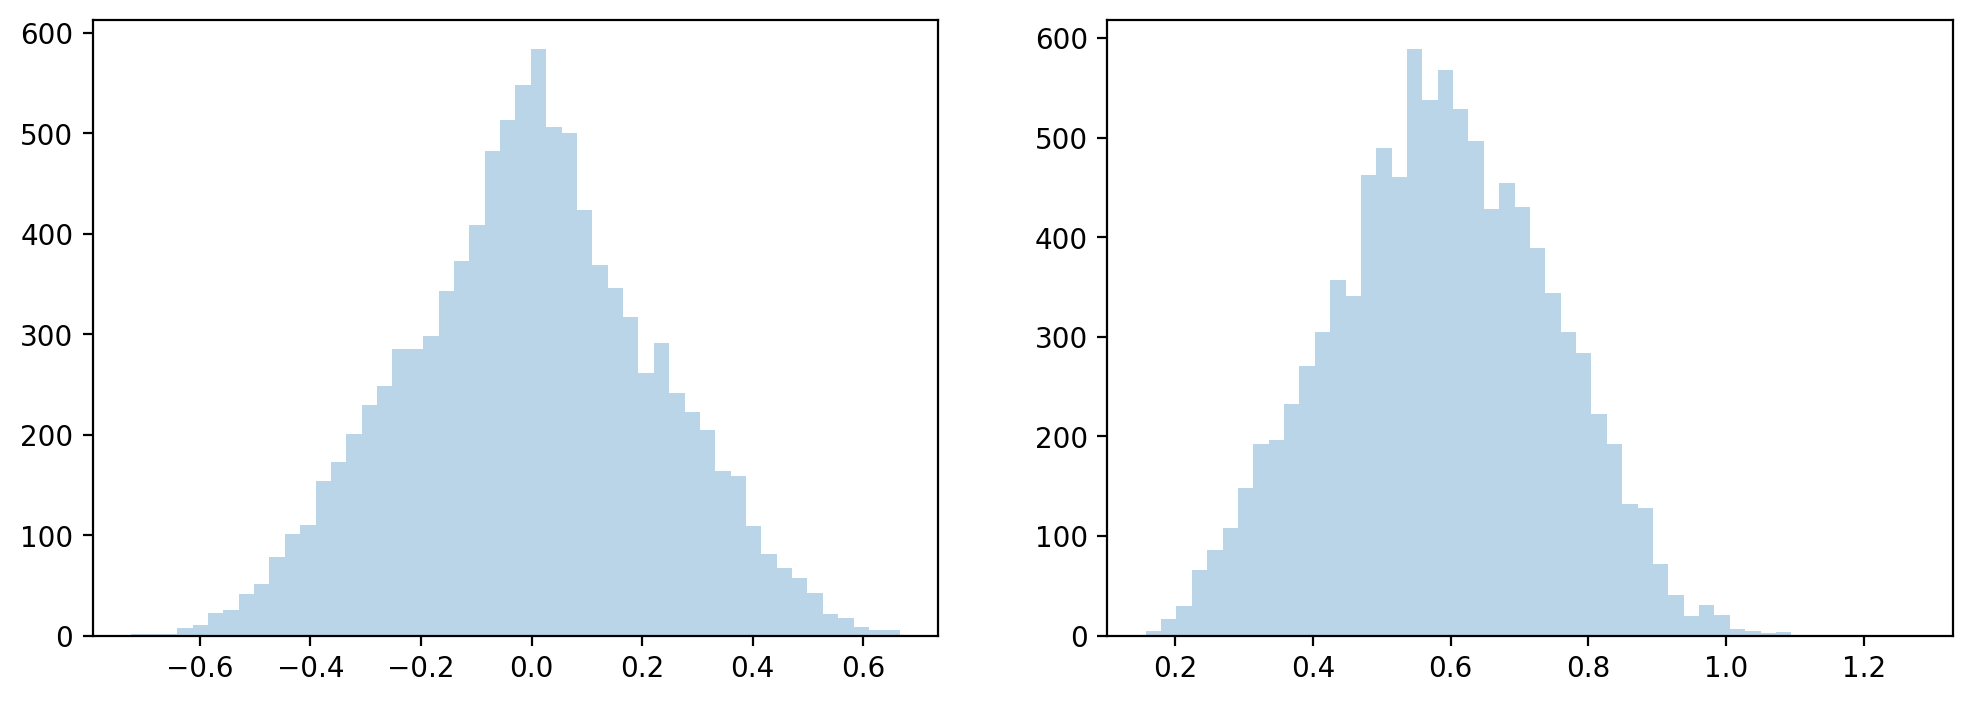

In [8]:
plt.figure(figsize=(12, 4), dpi=200)
plt.subplot(1, 2, 1)
plt.hist([i[0] for i in targets], 50, alpha=0.3)
plt.subplot(1, 2, 2)
plt.hist([i[1] for i in targets], 50, alpha=0.3)
